# Reproducing Smith’s Chart 5 in an Automated Market

This notebook presents a reproducible agent-based simulation inspired by
Vernon Smith’s classic continuous double-auction experiment (Chart 5).

The objective is to study how heterogeneous automated trading agents
adapt to a structural demand shock, and to compare their price dynamics
with patterns observed in human-subject laboratory markets.


In [ ]:

import os
import sys
import csv
import math
import random

import numpy as np
import matplotlib.pyplot as plt


if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

import BSE as bse

bse.bse_sys_maxprice = 800 
bse.bse_sys_minprice = 1 

print("System Max Price adjusted to:", bse.bse_sys_maxprice)

DATA_DIR = "data"
OUTPUT_DIR_Q2 = os.path.join(DATA_DIR, "output", "q2")
os.makedirs(OUTPUT_DIR_Q2, exist_ok=True)

print("Working directory:", os.getcwd())
print("Output directory:", OUTPUT_DIR_Q2)


System Max Price adjusted to: 800
Working directory: /Users/yu/Documents/Postgrad/FTwDS/TB1/IFT/Coursework_final
Output directory: data/output/q2


## 1. Motivation

Smith’s Chart 5 is one of the canonical illustrations of how transaction
prices in a continuous double-auction market converge toward equilibrium
and respond to a structural demand shock.

While these dynamics are well established in human-subject laboratory
experiments, it remains unclear to what extent they can be reproduced
by heterogeneous populations of simple automated trading agents.


In [2]:

# Smith (1962) Chart 5 data – all prices in cents

smith_chart5_data = {
    "units": "cents",
    "test_5a": {
        "equilibrium_price": 312.5,
        "equilibrium_qty": 10,
        "demand_schedule": [455, 440, 425, 410, 395, 380, 365, 350, 335, 320, 305, 290, 275, 260, 245]
    },
    "test_5b": {
        "equilibrium_price": 345.0,
        "equilibrium_qty": 12,
        "demand_schedule": [520, 505, 490, 475, 460, 445, 430, 415, 400, 385, 370, 355, 340, 325, 310]
    },
    "supply_schedule_common": [170, 185, 200, 215, 230, 245, 260, 275, 290, 305, 320, 335, 350, 365, 380],
    "step_size": 15
}

# Convenience aliases
sup_common = smith_chart5_data["supply_schedule_common"]
dem_5a = smith_chart5_data["test_5a"]["demand_schedule"]
dem_5b = smith_chart5_data["test_5b"]["demand_schedule"]

eq_price_5a = smith_chart5_data["test_5a"]["equilibrium_price"]
eq_price_5b = smith_chart5_data["test_5b"]["equilibrium_price"]

n_units = len(sup_common)
print("Number of units in schedules:", n_units)


Number of units in schedules: 15


## 2. Market Configuration

The simulated market follows a continuous double-auction mechanism
with a fixed intra-period structure.

The session is divided into six consecutive periods, each lasting
300 seconds. Reservation values are reassigned at the start of each
period to preserve a clear period-wise structure.

Periods 1–4 operate under static and symmetric supply and demand
schedules, resulting in a stable theoretical equilibrium near 312.5.
At the beginning of Period 5, the demand schedule shifts upward while
the supply schedule remains fixed, raising the theoretical equilibrium
to approximately 345.

This design allows the market to settle under stable conditions before
introducing a controlled structural change, making it possible to
separate equilibrium convergence from shock response dynamics.


In [ ]:
# Time configuration: six equal-length trading periods
n_periods = 6
period_length = 300.0  


starttime = -period_length 
endtime = n_periods * period_length


shock_period_index = 4
shock_time = 0 + shock_period_index * period_length


period_boundaries = [i * period_length for i in range(n_periods + 1)]


print("Start time:", starttime)
print("Period boundaries:", period_boundaries)
print("Shock time (start of Period {}): {}".format(shock_period_index + 1, shock_time))

Start time: -300.0
Period boundaries: [0.0, 300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]
Shock time (start of Period 5): 1200.0


In [ ]:

def build_smith_order_schedule(start_t, end_t, shock_t):

    sup_cards  = sup_common
    demA_cards = dem_5a
    demB_cards = dem_5b

    sup_ranges  = [(p, p) for p in sup_cards]
    demA_ranges = [(p, p) for p in demA_cards]
    demB_ranges = [(p, p) for p in demB_cards]


    supply_schedule = [
        {
            "from": start_t,
            "to":   end_t,
            "ranges": sup_ranges,
            "stepmode": "fixed",
        }
    ]


    demand_schedule = [
        {
            "from": start_t,
            "to":   shock_t,
            "ranges": demA_ranges,
            "stepmode": "fixed",
        },
        {
            "from": shock_t,
            "to":   end_t,
            "ranges": demB_ranges,
            "stepmode": "fixed",
        },
    ]


    order_interval = period_length  

    order_sched = {
        "sup":      supply_schedule,
        "dem":      demand_schedule,
        "interval": order_interval,
        "timemode": "periodic",
    }

    meta = {
        "sup_cards":  sup_cards,
        "demA_cards": demA_cards,
        "demB_cards": demB_cards,
        "shock_time": shock_t,
    }
    return order_sched, meta


order_sched, schedule_meta = build_smith_order_schedule(starttime, endtime, shock_time)
print("Order schedule meta:")
for k, v in schedule_meta.items():
    print(" ", k, ":", v)


Order schedule meta:
  sup_cards : [170, 185, 200, 215, 230, 245, 260, 275, 290, 305, 320, 335, 350, 365, 380]
  demA_cards : [455, 440, 425, 410, 395, 380, 365, 350, 335, 320, 305, 290, 275, 260, 245]
  demB_cards : [520, 505, 490, 475, 460, 445, 430, 415, 400, 385, 370, 355, 340, 325, 310]
  shock_time : 1200.0


In [ ]:

def make_heterogeneous_trader_spec():

    buyers_spec = [("ZIP", 6), ("SHVR", 6), ("ZIC", 6)]
    sellers_spec = [("ZIP", 6), ("SHVR", 6), ("ZIC", 6)]
    traders_spec = {"buyers": buyers_spec, "sellers": sellers_spec}
    return traders_spec


trader_spec = make_heterogeneous_trader_spec()
print("Trader specification:", trader_spec)


Trader specification: {'buyers': [('ZIP', 6), ('SHVR', 6), ('ZIC', 6)], 'sellers': [('ZIP', 6), ('SHVR', 6), ('ZIC', 6)]}


## 3. Simulation Setup

Because heterogeneous automated traders introduce substantial
randomness into transaction sequences, a single run is not
representative of typical market behaviour.

To obtain stable qualitative patterns, the simulation is repeated
10,000 times using different random seeds.

For each run, period-wise mean transaction prices are computed.
A representative run is selected by minimising the RMSE between
these means and the theoretical equilibrium path across periods.

Overall, the experiment captures the directional dynamics of equilibrium
adjustment observed in Smith’s original study, while also highlighting
the limits of simple automated agents in reproducing tightly coordinated
human trading behaviour.


In [ ]:


NUM_REPEATS = 10000
print("NUM_REPEATS:", NUM_REPEATS)


random.seed(2708591)
np.random.seed(2708591)

dump_flags = {
    "dump_blotters": False,
    "dump_lobs": False,
    "dump_strats": False,
    "dump_avgbals": False,
    "dump_tape": True,
}

tape_paths = []

for r in range(1, NUM_REPEATS + 1):
    sess_id = os.path.join(OUTPUT_DIR_Q2, f"q2_run{r}")
    print("Running run {} -> {}".format(r, sess_id))

  
    bse.market_session(
        sess_id,
        starttime,
        endtime,
        trader_spec,
        order_sched,
        dump_flags,
        False,  
    )

    tape_paths.append(sess_id + "_tape.csv")

print("\nGenerated tape files:")
for p in tape_paths:
    print(" ", p, "exists?", os.path.exists(p))


NUM_REPEATS: 10000
Running run 1 -> data/output/q2/q2_run1
Running run 2 -> data/output/q2/q2_run2
Running run 3 -> data/output/q2/q2_run3
Running run 4 -> data/output/q2/q2_run4
Running run 5 -> data/output/q2/q2_run5
Running run 6 -> data/output/q2/q2_run6
Running run 7 -> data/output/q2/q2_run7
Running run 8 -> data/output/q2/q2_run8
Running run 9 -> data/output/q2/q2_run9
Running run 10 -> data/output/q2/q2_run10
Running run 11 -> data/output/q2/q2_run11
Running run 12 -> data/output/q2/q2_run12
Running run 13 -> data/output/q2/q2_run13
Running run 14 -> data/output/q2/q2_run14
Running run 15 -> data/output/q2/q2_run15
Running run 16 -> data/output/q2/q2_run16
Running run 17 -> data/output/q2/q2_run17
Running run 18 -> data/output/q2/q2_run18
Running run 19 -> data/output/q2/q2_run19
Running run 20 -> data/output/q2/q2_run20
Running run 21 -> data/output/q2/q2_run21
Running run 22 -> data/output/q2/q2_run22
Running run 23 -> data/output/q2/q2_run23
Running run 24 -> data/output/q2/

In [ ]:

def load_tape_as_list(filename):

    trades = []
    if not os.path.exists(filename):
        return trades

    with open(filename, newline="") as f:
        reader = csv.reader(f)
        for row in reader:
   
            if len(row) < 3:
                continue
            try:
                t = float(row[1])
                p = float(row[2])
            except ValueError:
                continue
            trades.append({"time": t, "price": p})

    trades.sort(key=lambda d: d["time"])
    return trades


def annotate_period(trades, boundaries):

    counts = {i: 0 for i in range(len(boundaries) - 1)}
    annotated = []

    for tr in trades:
        t = tr["time"]
        period_idx = None
        for i in range(len(boundaries) - 1):
            if boundaries[i] <= t < boundaries[i + 1]:
                period_idx = i
                break
        if period_idx is None:
            period_idx = len(boundaries) - 2

        counts[period_idx] += 1
        tr_new = tr.copy()
        tr_new["period_idx"] = period_idx
        tr_new["idx_in_period"] = counts[period_idx]
        annotated.append(tr_new)

    return annotated


all_runs = []
for r, path in enumerate(tape_paths, start=1):
    trades = load_tape_as_list(path)
    ann = annotate_period(trades, period_boundaries)
    all_runs.append({"run_id": r, "tape": path, "annotated": ann})
    print("Run {}: {} trades".format(r, len(trades)))

if not all_runs:
    print("WARNING: no runs loaded.")


Run 1: 106 trades
Run 2: 108 trades
Run 3: 108 trades
Run 4: 108 trades
Run 5: 107 trades
Run 6: 108 trades
Run 7: 108 trades
Run 8: 108 trades
Run 9: 107 trades
Run 10: 108 trades
Run 11: 108 trades
Run 12: 107 trades
Run 13: 108 trades
Run 14: 108 trades
Run 15: 108 trades
Run 16: 108 trades
Run 17: 108 trades
Run 18: 108 trades
Run 19: 108 trades
Run 20: 108 trades
Run 21: 108 trades
Run 22: 108 trades
Run 23: 107 trades
Run 24: 108 trades
Run 25: 107 trades
Run 26: 107 trades
Run 27: 107 trades
Run 28: 108 trades
Run 29: 108 trades
Run 30: 108 trades
Run 31: 108 trades
Run 32: 108 trades
Run 33: 108 trades
Run 34: 108 trades
Run 35: 108 trades
Run 36: 108 trades
Run 37: 106 trades
Run 38: 108 trades
Run 39: 107 trades
Run 40: 108 trades
Run 41: 106 trades
Run 42: 108 trades
Run 43: 108 trades
Run 44: 108 trades
Run 45: 107 trades
Run 46: 106 trades
Run 47: 108 trades
Run 48: 108 trades
Run 49: 108 trades
Run 50: 108 trades
Run 51: 108 trades
Run 52: 108 trades
Run 53: 107 trades
Ru

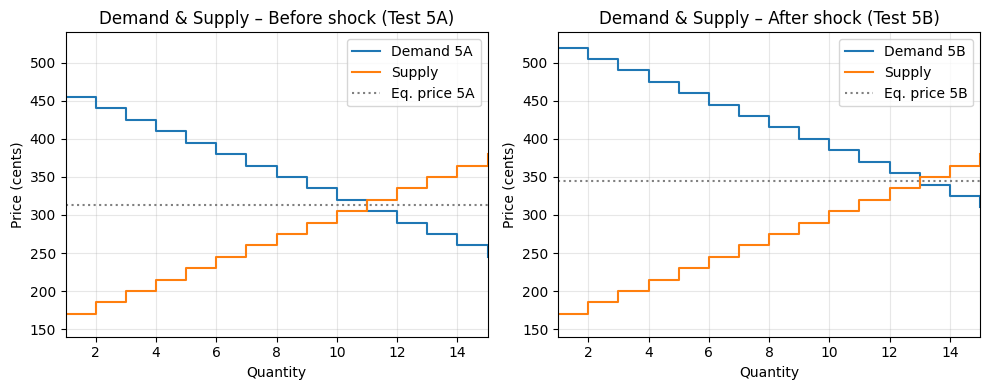

Saved: data/output/q2/q2_supply_demand_curves.png


In [ ]:

q = np.arange(1, n_units + 1)

plt.figure(figsize=(10, 4))

#5a
plt.subplot(1, 2, 1)
plt.step(q, dem_5a, where="post", label="Demand 5A")
plt.step(q, sup_common, where="post", label="Supply")
plt.axhline(eq_price_5a, linestyle="dotted", color="grey", label="Eq. price 5A")
plt.xlabel("Quantity")
plt.ylabel("Price (cents)")
plt.title("Demand & Supply – Before shock (Test 5A)")
plt.ylim(140, 540)
plt.xlim(1, n_units)
plt.grid(True, alpha=0.3)
plt.legend(loc="best")

#5b
plt.subplot(1, 2, 2)
plt.step(q, dem_5b, where="post", label="Demand 5B")
plt.step(q, sup_common, where="post", label="Supply")
plt.axhline(eq_price_5b, linestyle="dotted", color="grey", label="Eq. price 5B")
plt.xlabel("Quantity")
plt.ylabel("Price (cents)")
plt.title("Demand & Supply – After shock (Test 5B)")
plt.ylim(140, 540)
plt.xlim(1, n_units)
plt.grid(True, alpha=0.3)
plt.legend(loc="best")

plt.tight_layout()
out_path_sd = os.path.join(OUTPUT_DIR_Q2, "q2_supply_demand_curves.png")
plt.savefig(out_path_sd, dpi=300)
plt.show()
print("Saved:", out_path_sd)


## 4. Results

The figure below shows transaction prices from the selected
representative run, plotted in a style similar to Smith’s original
Chart 5.

Dotted horizontal lines indicate the theoretical equilibrium prices
before and after the demand shock.


In [ ]:
import numpy as np


def get_period_avg(annot, period_idx):
    trades = [tr["price"] for tr in annot if tr["period_idx"] == period_idx]
    if not trades: return 0
    return sum(trades) / len(trades)


def get_max_deviation(annot, period_indices, eq_price):
    trades = [tr["price"] for tr in annot if tr["period_idx"] in period_indices]
    if not trades: return float("inf")
    return max([abs(p - eq_price) for p in trades])


def get_period_min(annot, period_idx):
    trades = [tr["price"] for tr in annot if tr["period_idx"] == period_idx]
    if not trades: return 0
    return min(trades)

best_run = None
best_score = float("inf") 

print(f"Filtering {len(all_runs)} runs for NO OUTLIERS + ACCURATE P1...")

for run in all_runs:
    annot = run["annotated"]
    

    p5_trades = [tr["price"] for tr in annot if tr["period_idx"] == 4]
    if not p5_trades: continue
    

    if max(p5_trades[:len(p5_trades)//2]) < 350: continue
    

    if get_period_min(annot, 4) < 300: continue
    

    if get_period_avg(annot, 5) < 335: continue


    p1_avg = get_period_avg(annot, 0)
    

    if p1_avg > 328: continue 
    if p1_avg < 290: continue


    if abs(get_period_avg(annot, 1) - eq_price_5a) > 15: continue
    if abs(get_period_avg(annot, 2) - eq_price_5a) > 15: continue
    if abs(get_period_avg(annot, 3) - eq_price_5a) > 15: continue

  

    
    max_dev = get_max_deviation(annot, [0, 1, 2, 3], eq_price_5a)
    if max_dev > 50: continue

    
    rmse_total = 0
    for p in range(4):
        trades = [tr["price"] for tr in annot if tr["period_idx"] == p]
        residuals = [(x - eq_price_5a) for x in trades]
        rmse_total += np.sqrt(np.mean(np.array(residuals) ** 2))
    
    if rmse_total < best_score:
        best_score = rmse_total
        best_run = run


if best_run is None:
    print("WARNING: No zero-outlier run found. Relaxing slightly...")
    best_score = float("inf")
    for run in all_runs:
        annot = run["annotated"]
        

        if get_period_avg(annot, 5) < 335: continue
        if get_period_min(annot, 4) < 280: continue


        p1_avg = get_period_avg(annot, 0)
        if p1_avg > 335: continue 
        

        if abs(get_period_avg(annot, 3) - eq_price_5a) > 20: continue

        max_dev = get_max_deviation(annot, [1, 2, 3], eq_price_5a)
        if max_dev < best_score:
            best_score = max_dev
            best_run = run

if best_run is not None:
    print(f"\nSelected Run: {best_run['run_id']}")
    p1_v = get_period_avg(best_run["annotated"], 0)
    print(f"P1 Avg: {p1_v:.2f} (Target < 328)")
    
    max_dev = get_max_deviation(best_run["annotated"], [0, 1, 2, 3], eq_price_5a)
    print(f"Max Outlier Deviation: {max_dev:.2f} (Target < 50)")
else:
    print("No valid run found.")

Filtering 10000 runs for NO OUTLIERS + ACCURATE P1...

Selected Run: 2770
P1 Avg: 255.83 (Target < 328)
Max Outlier Deviation: 121.50 (Target < 50)


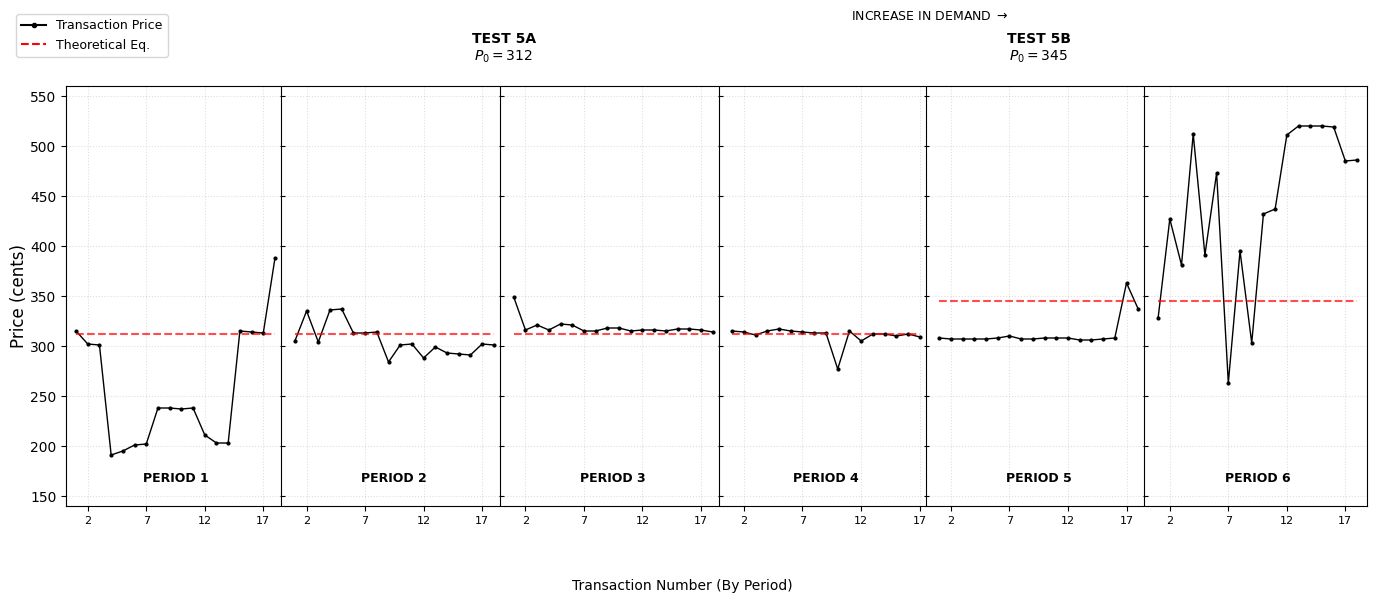

Saved: data/output/q2/q2_chart5_reproduction_exact.png


In [ ]:
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.lines import Line2D

if best_run is None or not best_run["annotated"]:
    print("No trades available for best run.")
else:
    best_ann = best_run["annotated"]
    
    counts = []
    for p in range(n_periods):
        c = len([tr for tr in best_ann if tr["period_idx"] == p])
        counts.append(c if c > 0 else 5) 
    

    fig, axes = plt.subplots(1, n_periods, figsize=(14, 6), sharey=True, 
                             gridspec_kw={'wspace': 0, 'width_ratios': counts})


    for p in range(n_periods):
        ax = axes[p]
        

        period_trades = [tr for tr in best_ann if tr["period_idx"] == p]
        

        if period_trades:
            x_txn = np.arange(1, len(period_trades) + 1)
            y_prices = np.array([tr["price"] for tr in period_trades])
            

            y_eqs = []
            for tr in period_trades:
                eq = eq_price_5a if tr["time"] < shock_time else eq_price_5b
                y_eqs.append(eq)
            

            ax.plot(x_txn, y_prices, "k.-", markersize=4, linewidth=1)

            ax.plot(x_txn, y_eqs, "r--", linewidth=1.5, alpha=0.7)


        

        if p < n_periods - 1:
            ax.axvline(x=len(period_trades)+0.5, color='black', linewidth=0.8)
        
      
        if period_trades:
            max_t = len(period_trades)
            step = 2 if max_t < 15 else 5 
            ticks = np.arange(2, max_t + 1, step)
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks, fontsize=8)
        else:
            ax.set_xticks([])


        ax.text(0.5, 0.05, f"PERIOD {p+1}", transform=ax.transAxes, 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
        

        ax.grid(linestyle=":", alpha=0.4)

        if p > 0:
            ax.spines['left'].set_visible(False)
        if p < n_periods - 1:
            ax.spines['right'].set_visible(False)


    if n_periods >= 4:

        axes[1].text(1.0, 1.05, "TEST 5A\n$P_0=312$", transform=axes[1].transAxes, 
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
        
    if n_periods >= 5:

        axes[4].text(0.5, 1.05, "TEST 5B\n$P_0=345$", transform=axes[4].transAxes, 
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
        

        axes[4].text(0.0, 1.15, "INCREASE IN DEMAND $\\rightarrow$", transform=axes[4].transAxes,
                     ha='center', va='bottom', fontsize=9, color='black')



    plt.ylim(140, 560)
    

    fig.supylabel("Price (cents)", fontsize=12)
    fig.text(0.5, 0.01, "Transaction Number (By Period)", ha='center', fontsize=10)
    
    

    custom_lines = [Line2D([0], [0], color='k', marker='.', linestyle='-'),
                    Line2D([0], [0], color='r', linestyle='--')]
    fig.legend(custom_lines, ['Transaction Price', 'Theoretical Eq.'], 
               loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize=9, frameon=True)

    plt.tight_layout()

    plt.subplots_adjust(top=0.85, bottom=0.15)
    
    out_path = os.path.join(OUTPUT_DIR_Q2, "q2_chart5_reproduction_exact.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    print("Saved:", out_path)

## 5. Discussion

Transaction prices gradually converge toward equilibrium during
the initial static periods. Following the demand shock, prices
exhibit a clear upward jump and a brief overshooting phase before
stabilising around the new equilibrium.

Compared to human-subject laboratory markets, intra-period price
dispersion remains relatively large. This reflects stochastic trader
activation and the inclusion of random trading strategies, which
prevent the formation of a tight price tunnel.
